# Compare COVID-19 data for a number of countries
### Source of data is wikipedia.org

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import data_scraper as ds

pd.set_option('display.max_rows', 100)

In [2]:
def get_data(countries, download=False):
    """
    Return dataframe with wikipedia Corona data for countries. Download fresh
    data if download is set to True, otherwise use data in pickle file.
    """
    if download:
        df = ds.download_data(countries)
        df.to_pickle('wikipedia_data.pickle')
        return df
    return pd.read_pickle('wikipedia_data.pickle')

def date_first_observation(df, cases_or_deaths, row):
    column_name = cases_or_deaths + '_' + row.name
    row_index = df[df[column_name] > 0].first_valid_index()
    return df.loc[row_index, 'date']

def max_value(df, cases_or_deaths, row):
    column_name = cases_or_deaths + '_' + row.name
    return df[column_name].max()

def max_value_index(df, cases_or_deaths, row):
    column_name = cases_or_deaths + '_' + row
    return df[column_name].idxmax()

def average_increase_last_days(df, cases_or_deaths, days, row):
    "Return average increase in cases/deaths over the last x days."
    column_name = cases_or_deaths + '_' + row.name
    end_index = df[column_name].idxmax()
    start_index = end_index - days
    start = wiki_data.loc[start_index, column_name]
    end = wiki_data.loc[end_index, column_name]
    return (end - start) / days

In [3]:
populations = ds.population_table()
all_countries = ds.wiki_shortcodes.keys()
# to download the latest data set download argument to True
wiki_data = get_data(all_countries ,download=False)

In [4]:
# list of all countries with data
all_countries = ds.country_names
# dataframe with all countries
corona = pd.DataFrame(all_countries.items(), columns=['cc', 'country'])
# set index
corona = corona.set_index('cc')
# remove index name
corona.index.name = None
# column with date of first case
corona['first_case'] = corona.apply(
    lambda row: date_first_observation(wiki_data, 'cases', row), axis=1)
# column with date of first death
corona['first_death'] = corona.apply(
    lambda row: date_first_observation(wiki_data, 'deaths', row), axis=1)
# column with total cases
corona['cases_total'] = corona.apply(lambda row: max_value(wiki_data, 'cases', row), axis=1)
# column with total deaths
corona['deaths_total'] = corona.apply(lambda row: max_value(wiki_data, 'deaths', row), axis=1)
# column with cases per million citizens
corona['cases_pM'] = corona.cases_total / pd.Series(populations) * 1000000
# column with deaths per million citizens
corona['deaths_pM'] = corona.deaths_total / pd.Series(populations) * 1000000
# column with average cases over last 5 days
corona['cases_al5d'] = corona.apply(
    lambda row: average_increase_last_days(wiki_data, 'cases', 5, row), axis=1)
corona['deaths_al5d'] = corona.apply(
    lambda row: average_increase_last_days(wiki_data, 'deaths', 5, row), axis=1)
corona['cases_al10d'] = corona.apply(
    lambda row: average_increase_last_days(wiki_data, 'cases', 10, row), axis=1)
corona['deaths_al10d'] = corona.apply(
    lambda row: average_increase_last_days(wiki_data, 'deaths', 10, row), axis=1)

In [5]:
# sort descending by number of deaths
corona.sort_values('deaths_total', inplace=True, ascending=False)
# column formats
format_dict = {'first_case': '{:%d-%b-%Y}', 'first_death': '{:%d-%b-%Y}',
               'cases_pM': '{:,.0f}', 'deaths_pM': '{:,.0f}',
               'cases_total': '{:,d}', 'deaths_total': '{:,d}',
               'cases_al5d': '{:,.0f}', 'deaths_al5d': '{:,.0f}',
               'cases_al10d': '{:,.0f}', 'deaths_al10d': '{:,.0f}'}
corona.style.format(format_dict).hide_index()

country,first_case,first_death,cases_total,deaths_total,cases_pM,deaths_pM,cases_al5d,deaths_al5d,cases_al10d,deaths_al10d
us,21-Jan-2020,06-Feb-2020,"983,063","50,352","2,970",152,"30,558","1,631","28,644","1,791"
italy,31-Jan-2020,21-Feb-2020,"199,414","26,977","3,298",446,"2,417",378,"2,698",423
spain,31-Jan-2020,13-Feb-2020,"229,422","23,521","4,907",503,"4,207",361,"3,858",404
france,25-Feb-2020,25-Feb-2020,"128,339","23,293","1,966",357,"1,838",391,"1,909",461
uk,31-Jan-2020,05-Mar-2020,"157,149","21,092","2,315",311,"4,731",598,"4,846",652
ny_state,01-Mar-2020,14-Mar-2020,"291,996","17,303","15,010",889,"6,956",400,"6,235",448
belgium,04-Feb-2020,10-Mar-2020,"46,687","7,207","4,028",622,960,189,"1,055",204
germany,24-Feb-2020,09-Mar-2020,"155,193","5,750","1,852",69,"1,900",174,"2,136",188
netherlands,27-Feb-2020,06-Mar-2020,"38,245","4,518","2,232",264,681,93,780,106
canada,25-Jan-2020,09-Mar-2020,"48,500","2,707","1,285",72,"1,662",147,"1,657",140


In [6]:
def filter_columns(df, start_string):
    """Return list of columns in dataframe that start with start_string."""
    return [col for col in df.columns if col.startswith(start_string)]


def rename_columns(old_names):
    """Return dictionary with old column names as keys and new ones as values."""
    new_names = {}
    for col in old_names:
        new_names[col] = ds.country_names[col[-2:]]
    return new_names


def start_indices(df, threshold, num_type='int64'):
    """
    For each numeric column in dataframe find index of row where value is
    equal or above threshold. Return as dictionary.
    """
    numeric_columns = df.select_dtypes(num_type).columns
    start_indices = {}
    for col in numeric_columns:
        indices = df[df[col] >= threshold].index
        start_indices[col] = indices[0]
    return start_indices


def growth_table(df, threshold):
    """
    Generate dataframe with cases/deaths by country. Only select rows where total
    is above threshold. Reindex the data for each country before adding to
    dataframe, which enables comparing growth in countries from the same base.
    For example start table from when each country had >= 10 deaths.
    """
    indices = start_indices(df, threshold)
    countries = list(indices.keys())
    base_country = countries[0]
    frame = pd.DataFrame(df.loc[indices[base_country]:, base_country])
    frame = frame.reset_index(drop=True)
    for country in countries[1:]:
        frame2 = pd.DataFrame(df.loc[indices[country]:, country])
        frame2 = frame2.reset_index(drop=True)
        frame = frame.merge(frame2, how='outer', left_index=True, right_index=True)
    # replace remaining 0 with nan (for example, UK often report deaths day later)
    frame = frame.replace(0, np.nan)
    return frame

def country_dataframe(data, shortcode):
    """
    create a dataframe with the COVID-19 data for a specific country
    data(dataframe): source data
    shortcode(string): two-letter code for country
    """
    cols = [data.columns[0]] + [c for c in data.columns if c.endswith(shortcode)]
    df = data.loc[:, cols]
    # rename columns
    df.columns = ['date', 'cases_total', 'deaths_total']
    # filter out rows with 0 cases
    df = df[df.cases_total > 0]
    df = df.reset_index(drop=True)
    # daily cases column
    df.insert(1, 'cases', df.cases_total - df.cases_total.shift(1))
    df.loc[0, 'cases'] = df.loc[0, 'cases_total']
    # daily deaths column
    df.insert(3, 'deaths', df.deaths_total - df.deaths_total.shift(1))
    df.loc[0, 'deaths'] = df.loc[0, 'deaths_total']
    # change column types to integer
    df.loc[:, ['cases', 'deaths']] = df.loc[:, ['cases', 'deaths']].astype('int')
    # growth percentage columns
    df.insert(3, 'cases_gpct', df.cases / (df.cases_total - df.cases))
    df['deaths_gpct'] = df.deaths / (df.deaths_total - df.deaths)
    # growth factor columns
    df.insert(4, 'cases_gf', df.cases / df.cases.shift(1))
    df['deaths_gf'] = df.deaths / df.deaths.shift(1)
    # replace NaN values by 0
    df = df.replace(np.nan, 0)
    # 7-day averages
    df.insert(2, 'cases_7da', df.cases.rolling(window=7).mean())
    df.insert(7, 'deaths_7da', df.deaths.rolling(window=7).mean())
    return df

In [7]:
# list of required columns for deaths dataframe
deaths_cols = ['date'] + filter_columns(wiki_data, 'deaths')
# deaths dataframe
deaths_raw = wiki_data.loc[:, deaths_cols]
# dictionary with new column names
new_column_names = rename_columns(deaths_raw.columns[1:])
# rename columns
deaths_raw = deaths_raw.rename(columns=new_column_names)

In [8]:
start_value = 10
deaths = growth_table(deaths_raw, start_value)

In [9]:
max_row = deaths.italy.idxmax()
graph_countries = ['france', 'netherlands', 'uk', 'italy', 'spain', 'us', 'ny_state',
                   'sweden', 'austria', 'belgium', 'germany']
graph_country_colors = ['xkcd:cyan', 'xkcd:orange', 'xkcd:violet', 'xkcd:olive',
                        'xkcd:golden yellow', 'xkcd:hot pink', 'xkcd:dark pink',
                        'xkcd:blue', 'xkcd:red', 'xkcd:neon green', 'xkcd:black']
deaths_log = np.log10(deaths.loc[:max_row, graph_countries])

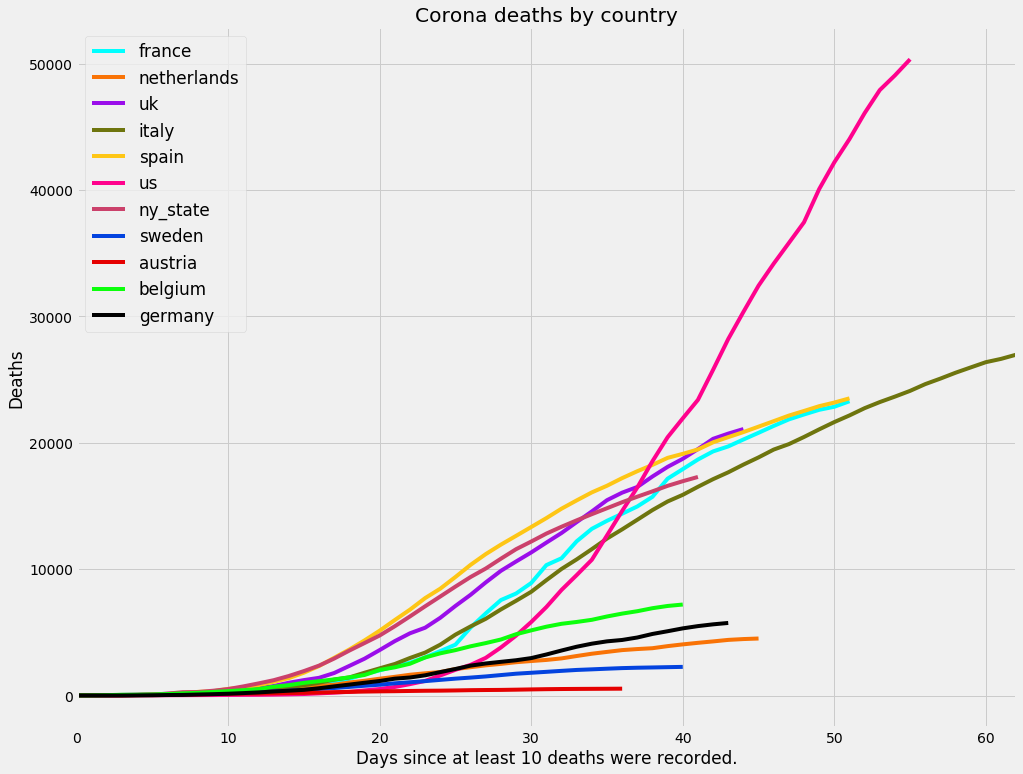

In [10]:
plt.style.use('fivethirtyeight')

graph_data = deaths.loc[: max_row, graph_countries]

fig, ax = plt.subplots(figsize=(15, 12))
ax.set_prop_cycle(color=graph_country_colors)
graph_data.plot(kind='line', y=graph_data.columns, use_index=True, ax=ax)
x_label = f'Days since at least {start_value} deaths were recorded.'
ax.set(title='Corona deaths by country', xlabel=x_label, ylabel='Deaths')
ax.legend(loc='upper left', fontsize='large');

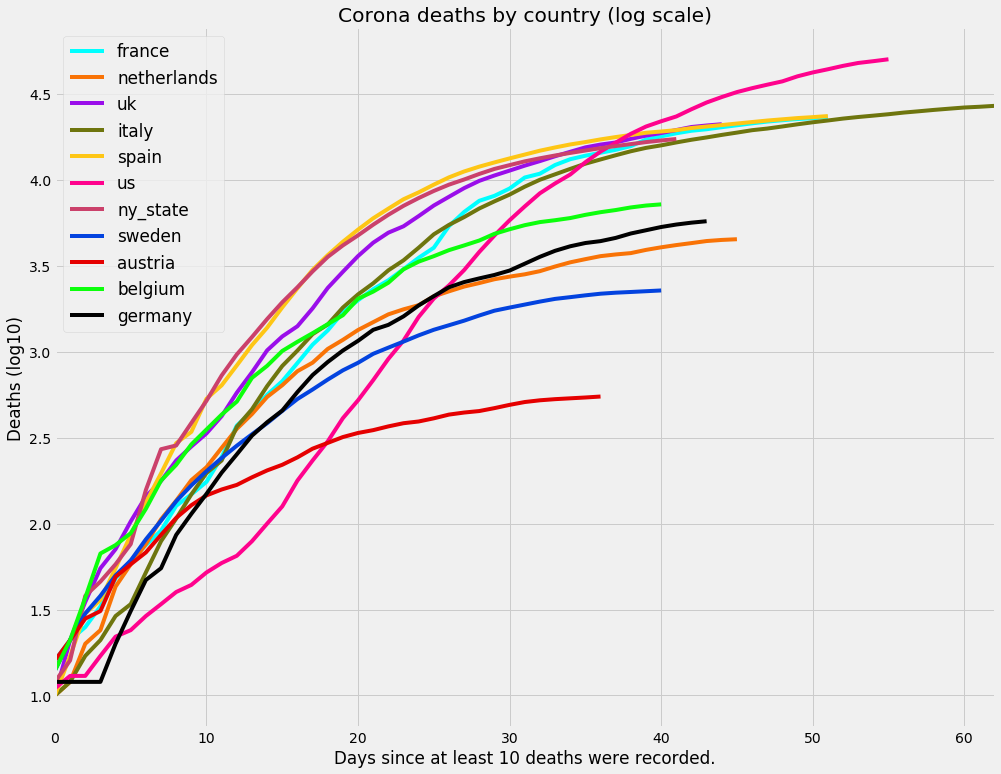

In [11]:
fig2, ax2 = plt.subplots(figsize=(15, 12))
ax2.set_prop_cycle(color=graph_country_colors)
deaths_log.plot(kind='line', y=deaths_log.columns, use_index=True, ax=ax2)
ax2.set(title='Corona deaths by country (log scale)', xlabel=x_label, ylabel='Deaths (log10)')
ax2.legend(loc='upper left', fontsize='large');

In [12]:
us = country_dataframe(wiki_data, 'us')
us

,date,cases,cases_7da,cases_total,cases_gpct,cases_gf,deaths,deaths_7da,deaths_total,deaths_gpct,deaths_gf
0,2020-01-21,1,NaN,1,inf,0.000000,0,NaN,0,0.000000,0.000000
1,2020-01-22,0,NaN,1,0.000000,0.000000,0,NaN,0,0.000000,0.000000
2,2020-01-23,0,NaN,1,0.000000,0.000000,0,NaN,0,0.000000,0.000000
3,2020-01-24,1,NaN,2,1.000000,inf,0,NaN,0,0.000000,0.000000
4,2020-01-25,1,NaN,3,0.500000,1.000000,0,NaN,0,0.000000,0.000000
5,2020-01-26,2,NaN,5,0.666667,2.000000,0,NaN,0,0.000000,0.000000
6,2020-01-27,0,0.714286,5,0.000000,0.000000,0,0.000000,0,0.000000,0.000000
7,2020-01-28,0,0.571429,5,0.000000,0.000000,0,0.000000,0,0.000000,0.000000
8,2020-01-29,0,0.571429,5,0.000000,0.000000,0,0.000000,0,0.000000,0.000000
9,2020-01-30,1,0.714286,6,0.200000,inf,0,0.000000,0,0.000000,0.000000


In [13]:
ny = country_dataframe(wiki_data, 'ny')
ny

,date,cases,cases_7da,cases_total,cases_gpct,cases_gf,deaths,deaths_7da,deaths_total,deaths_gpct,deaths_gf
0,2020-03-01,1,NaN,1,inf,0.000000,0,NaN,0,0.000000,0.000000
1,2020-03-02,0,NaN,1,0.000000,0.000000,0,NaN,0,0.000000,0.000000
2,2020-03-03,1,NaN,2,1.000000,inf,0,NaN,0,0.000000,0.000000
3,2020-03-04,9,NaN,11,4.500000,9.000000,0,NaN,0,0.000000,0.000000
4,2020-03-05,11,NaN,22,1.000000,1.222222,0,NaN,0,0.000000,0.000000
5,2020-03-06,22,NaN,44,1.000000,2.000000,0,NaN,0,0.000000,0.000000
6,2020-03-07,32,10.857143,76,0.727273,1.454545,0,0.000000,0,0.000000,0.000000
7,2020-03-08,29,14.857143,105,0.381579,0.906250,0,0.000000,0,0.000000,0.000000
8,2020-03-09,37,20.142857,142,0.352381,1.275862,0,0.000000,0,0.000000,0.000000
9,2020-03-10,31,24.428571,173,0.218310,0.837838,0,0.000000,0,0.000000,0.000000


In [14]:
nl = country_dataframe(wiki_data, 'nl')
nl

,date,cases,cases_7da,cases_total,cases_gpct,cases_gf,deaths,deaths_7da,deaths_total,deaths_gpct,deaths_gf
0,2020-02-27,1,NaN,1,inf,0.000000,0,NaN,0,0.000000,0.000000
1,2020-02-28,1,NaN,2,1.000000,1.000000,0,NaN,0,0.000000,0.000000
2,2020-02-29,4,NaN,6,2.000000,4.000000,0,NaN,0,0.000000,0.000000
3,2020-03-01,3,NaN,9,0.500000,0.750000,0,NaN,0,0.000000,0.000000
4,2020-03-02,10,NaN,19,1.111111,3.333333,0,NaN,0,0.000000,0.000000
5,2020-03-03,5,NaN,24,0.263158,0.500000,0,NaN,0,0.000000,0.000000
6,2020-03-04,14,5.428571,38,0.583333,2.800000,0,0.000000,0,0.000000,0.000000
7,2020-03-05,44,11.571429,82,1.157895,3.142857,0,0.000000,0,0.000000,0.000000
8,2020-03-06,46,18.000000,128,0.560976,1.045455,1,0.142857,1,inf,inf
9,2020-03-07,60,26.000000,188,0.468750,1.304348,0,0.142857,1,0.000000,0.000000


In [15]:
se = country_dataframe(wiki_data, 'se')
se

,date,cases,cases_7da,cases_total,cases_gpct,cases_gf,deaths,deaths_7da,deaths_total,deaths_gpct,deaths_gf
0,2020-02-04,1,NaN,1,inf,0.000000,0,NaN,0,0.000000,0.000000
1,2020-02-05,0,NaN,1,0.000000,0.000000,0,NaN,0,0.000000,0.000000
2,2020-02-06,0,NaN,1,0.000000,0.000000,0,NaN,0,0.000000,0.000000
3,2020-02-07,0,NaN,1,0.000000,0.000000,0,NaN,0,0.000000,0.000000
4,2020-02-08,0,NaN,1,0.000000,0.000000,0,NaN,0,0.000000,0.000000
5,2020-02-09,0,NaN,1,0.000000,0.000000,0,NaN,0,0.000000,0.000000
6,2020-02-10,0,0.142857,1,0.000000,0.000000,0,0.000000,0,0.000000,0.000000
7,2020-02-11,0,0.000000,1,0.000000,0.000000,0,0.000000,0,0.000000,0.000000
8,2020-02-12,0,0.000000,1,0.000000,0.000000,0,0.000000,0,0.000000,0.000000
9,2020-02-13,0,0.000000,1,0.000000,0.000000,0,0.000000,0,0.000000,0.000000


In [16]:
nl

,date,cases,cases_7da,cases_total,cases_gpct,cases_gf,deaths,deaths_7da,deaths_total,deaths_gpct,deaths_gf
0,2020-02-27,1,NaN,1,inf,0.000000,0,NaN,0,0.000000,0.000000
1,2020-02-28,1,NaN,2,1.000000,1.000000,0,NaN,0,0.000000,0.000000
2,2020-02-29,4,NaN,6,2.000000,4.000000,0,NaN,0,0.000000,0.000000
3,2020-03-01,3,NaN,9,0.500000,0.750000,0,NaN,0,0.000000,0.000000
4,2020-03-02,10,NaN,19,1.111111,3.333333,0,NaN,0,0.000000,0.000000
5,2020-03-03,5,NaN,24,0.263158,0.500000,0,NaN,0,0.000000,0.000000
6,2020-03-04,14,5.428571,38,0.583333,2.800000,0,0.000000,0,0.000000,0.000000
7,2020-03-05,44,11.571429,82,1.157895,3.142857,0,0.000000,0,0.000000,0.000000
8,2020-03-06,46,18.000000,128,0.560976,1.045455,1,0.142857,1,inf,inf
9,2020-03-07,60,26.000000,188,0.468750,1.304348,0,0.142857,1,0.000000,0.000000


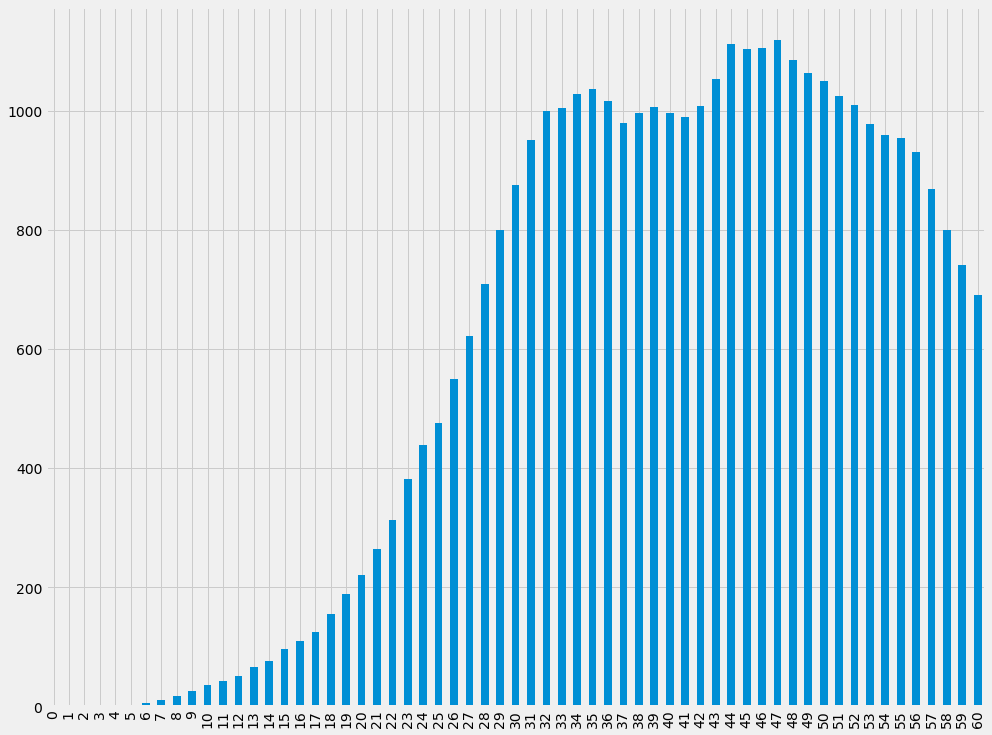

In [17]:
nl.cases_7da.plot(kind='bar', figsize=(15,12));

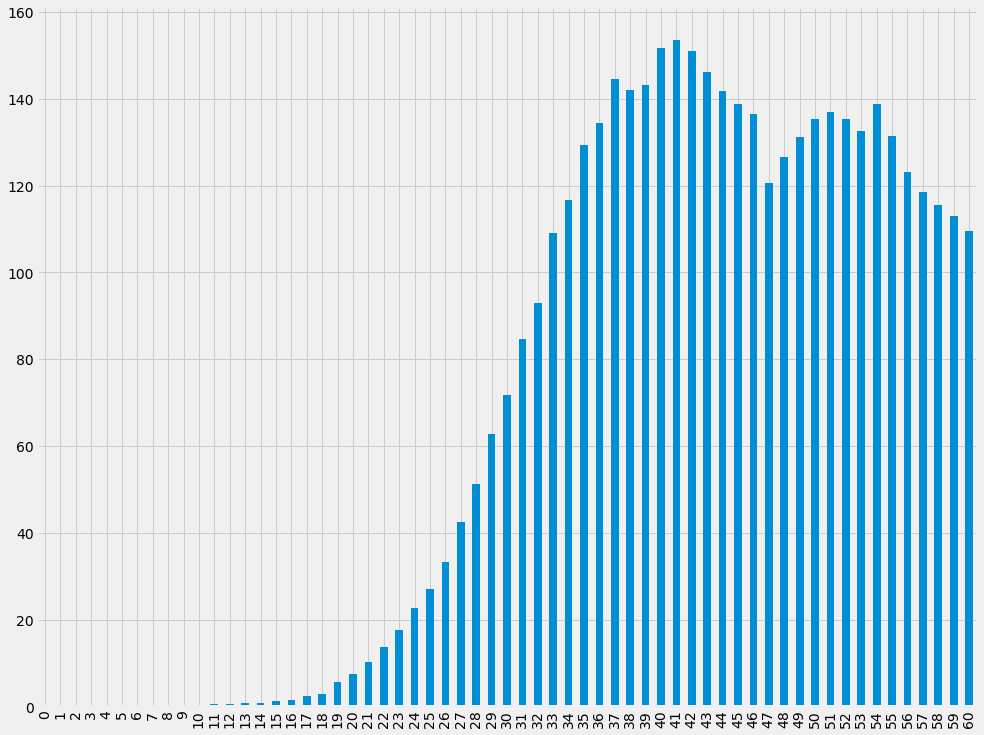

In [18]:
nl.deaths_7da.plot(kind='bar', figsize=(15,12));

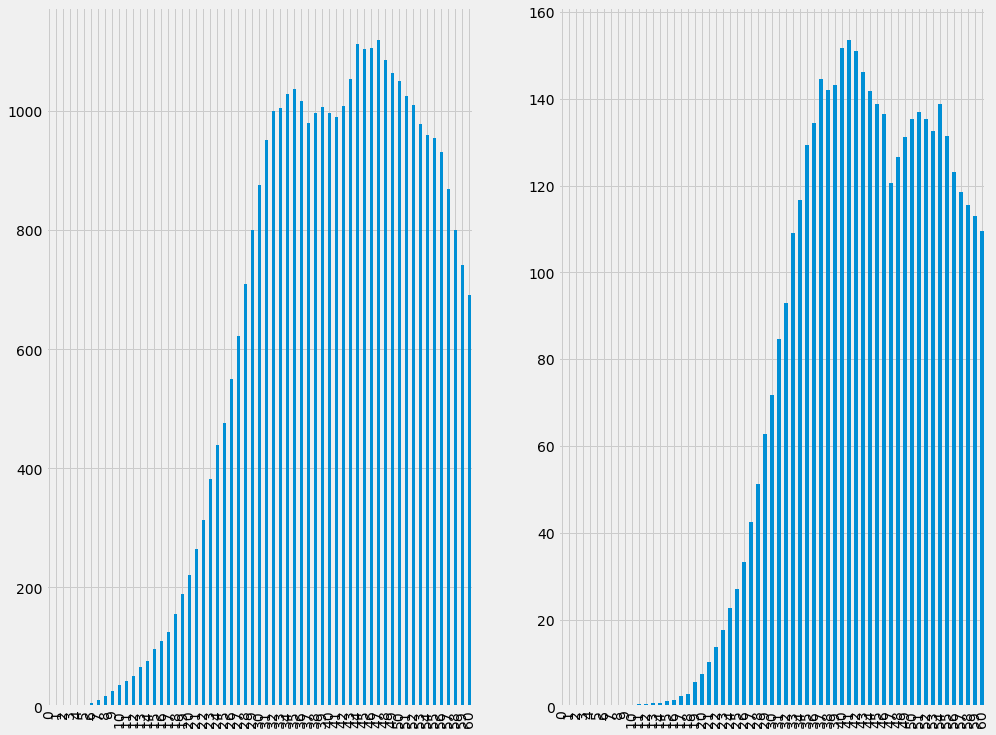

In [19]:
fig3, axs3 = plt.subplots(1, 2, figsize=(15, 12))

nl.cases_7da.plot(kind='bar', ax=axs3[0])
nl.deaths_7da.plot(kind='bar', ax=axs3[1]);